# Viscous streaming solution in frequency domain

In this notebook, we seek to solve for viscous streaming in the frequency domain.

$$ \mathcal{L}_\alpha u = i\alpha u  - L u = f $$

where $\alpha$ is a real-valued constant, $L$ is the grid Laplacian operator, and $u$ is a complex-valued field on the grid. It should be noted that $\alpha = \omega \Delta x^2/\nu$, where $\omega$ is a frequency, $\nu$ is kinematic viscosity, and $\Delta x$ is the grid spacing. The operator $\mathcal{L}_\alpha$ we will call the Helmholtz operator.

In [1]:
using Pkg
pkg"activate ."

Activating environment at `~/JuliaProjects/ViscousStreaming/Project.toml`


In [37]:
using Plots

In [1]:
using Revise

In [8]:
using ViscousStreaming

┌ Info: Precompiling ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1242


In [9]:
Re = 40
ϵ = 0.1

0.1

### Set up analytical solution

In [11]:
p = StreamingParams(ϵ,Re)

Streaming flow parameters with Re = 40.0, ϵ = 0.1


In [14]:
s = StreamingAnalytical(p)

Maximum residual on W₁ = 1.1368683772161603e-13
BC residual on Ψ₁(1) = 2.7755575615628914e-17
BC residual on dΨ₁(1) = 5.23691153334427e-16
Maximum residual on Ws₂ = 1.3073986337985843e-12
BC residual on Ψs₂(1) = 0.0
BC residual on dΨs₂(1) = 8.881784197001252e-16
Maximum residual on W₂ = 2.1179418493558537e-12
BC residual on Ψ₂(1) = 1.734723475976807e-17
BC residual on dΨ₂(1) = 0.0


Analytical streaming flow solution for
single cylinder with Re = 40.0, ϵ = 0.1


### Set up the basic system

#### Set up the grid cell size and approximate dimensions

In [15]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)

(-5.98, 5.98)

#### Set up a body

In [ ]:
n = 150
body = Circle(1.0,n)

In [ ]:
@time solver1 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,body);

In [86]:
solver1 = sys1;

In [87]:
soln = solver1([1.0,0.0],body);

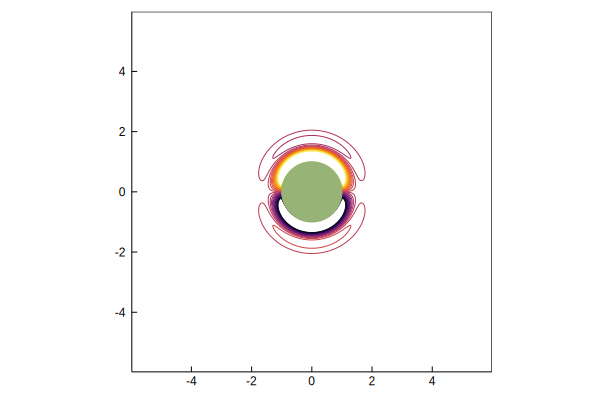

In [88]:
xg, yg = coordinates(soln.s1.W,sys.grid)
plot(xg,yg,real(soln.s1.W),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(body)

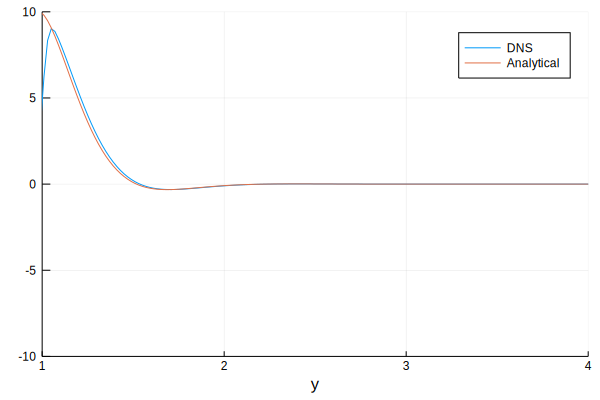

In [89]:
ix = 301
plot(yg,real(soln.s1.W)[301,:],ylim=(-10,10),xlim=(1,4),label="DNS",xlabel="y")
plot!(yg,map(y -> vorticity(xg[ix],y,0.0,firstorder(s)),abs.(yg)),label="Analytical")

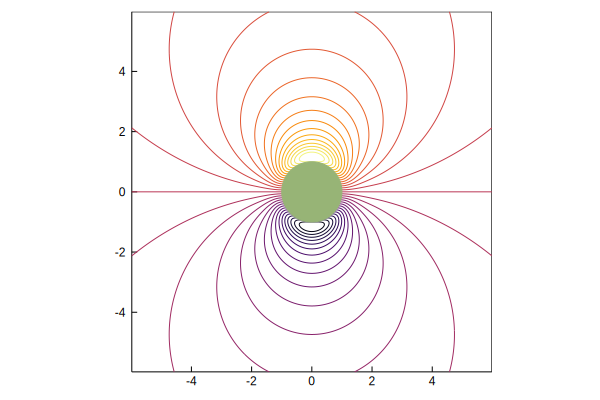

In [90]:
plot(xg,yg,real(soln.s1.Ψ),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)

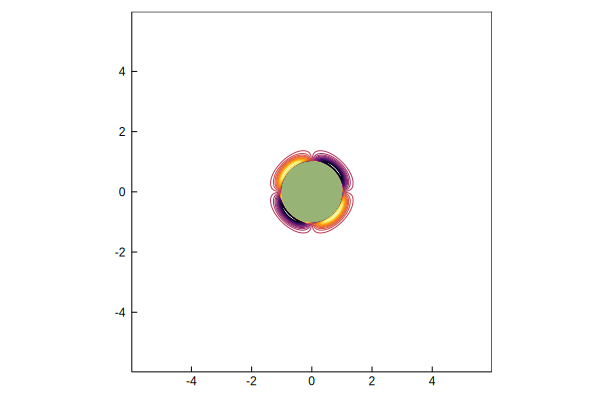

In [91]:
plot(xg,yg,real(soln.s̄2.W),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(body)

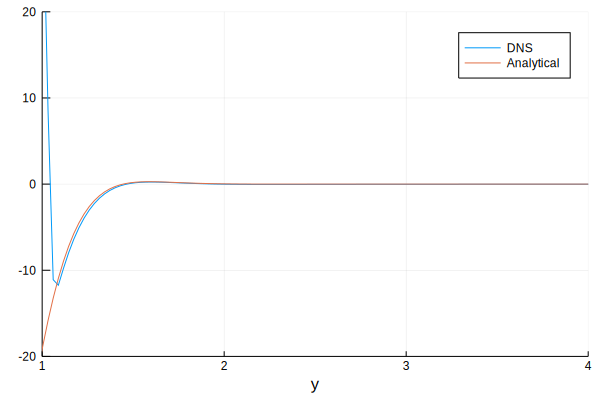

In [92]:
rg = sqrt.(xg.^2+yg.^2)
plot(rg,map(ix -> real(soln.s̄2.W)[ix,ix],1:length(rg)),ylim=(-20,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(rg,map(x -> vorticity(x,x,secondordermean(s)),xg),label="Analytical")

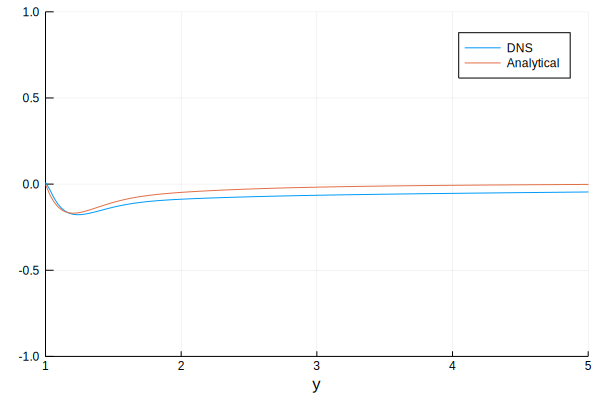

In [93]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> real(soln.s̄2.Ψ)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(1,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> streamfunction(x,x,secondordermean(s)),xg[ig:end]),label="Analytical")

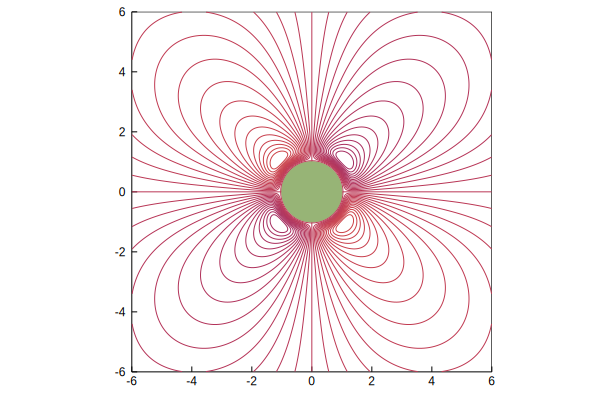

In [94]:
plot(xg,yg,real(soln.s̄2.Ψ + soln.sd.Ψ),levels=range(-0.1,0.1,length=31),clim=(-1,1),xlim=(-6,6),ylim=(-6,6))
plot!(body)

### Now multiple bodies

In [95]:
bl = BodyList()

BodyList(Body[])

In [96]:
bL = deepcopy(body)
bR = deepcopy(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [97]:
# left cylinder
cent = (-3.0,0.0)
α = 0.0
TL = RigidTransform(cent,α)
TL(bL) # transform the body to the current configuration

# right cylinder
cent = (3.0,0.0)
α = 0.0
TR = RigidTransform(cent,α)
TR(bR) # transform the body to the current configuration

push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

#### Set up the system

In [25]:
@time solver2 = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,bl);

183.528312 seconds (1.47 G allocations: 103.231 GiB, 12.85% gc time)


In [100]:
soln = solver2([[1.0,0.0],[0.0,0.0]],bl);

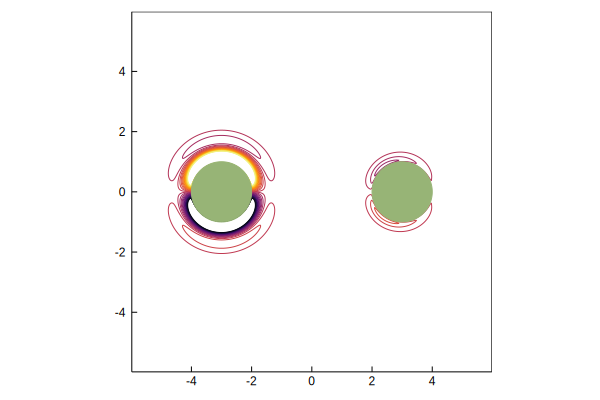

In [101]:
xg, yg = coordinates(soln.s1.W,sys.grid)
plot(xg,yg,real(soln.s1.W),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(bl)

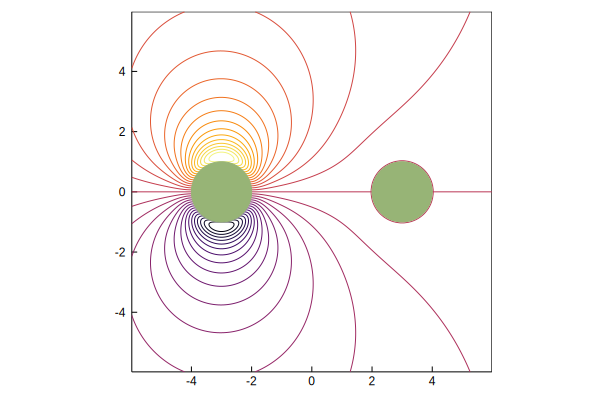

In [103]:
plot(xg,yg,real(soln.s1.Ψ),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(bl)

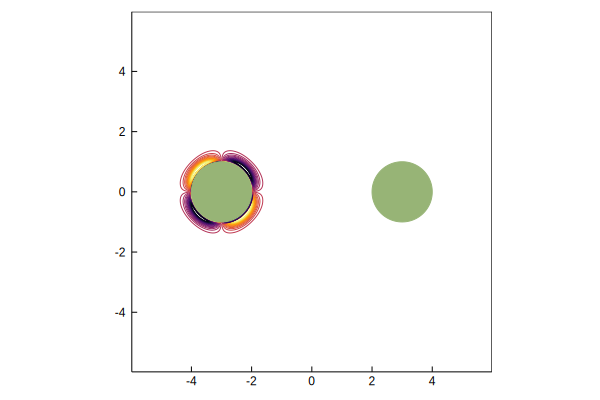

In [104]:
plot(xg,yg,real(soln.s̄2.W),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(bl)

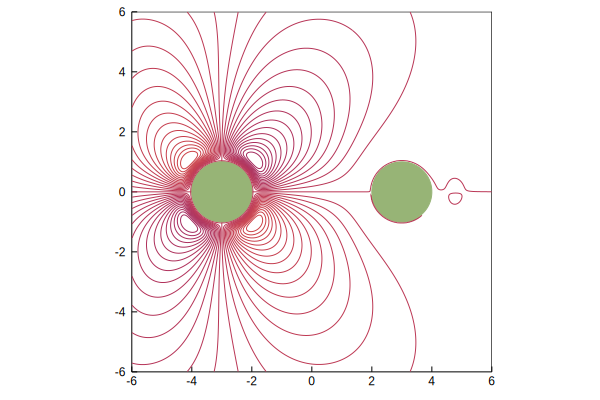

In [105]:
plot(xg,yg,real(soln.s̄2.Ψ + soln.sd.Ψ),levels=range(-0.1,0.1,length=31),clim=(-1,1),xlim=(-6,6),ylim=(-6,6))
plot!(bl)